In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats

plt.rcParams["figure.figsize"] = (10,10)



# THE GRAPH CONTROL PANEL

In [2]:
N =300  # Number of nodes
setting='home'    #the setting we are evaluating(home,work,school,other)
D=360#number of days the model runs
increase_rate=.2 #the rate of increasing weight per contact
lower_weight=0  #the minimum weight between two node
upper_weight=50    #the maximum weight between two node
threshold_n=1     #threshold of product weight two nodes with same neighbor for increasing weight
increse_rate_n=0  #increse rate weight for two nodes with same neighbor

## 1-Defining Nodes

In [3]:
G = nx.DiGraph()

In [4]:
#defining a dictionary of nodes
available_groups  = [] #16_age_groups
group_popularity = [] #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict()

with open ('population.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        available_groups.append(row[0])
        group_popularity.append(float(row[1]))
        
with open ('varicella_prevalance.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        v_prevalence[row[0]]=[float(row[1]),float(row[2])]
        
        


for i in range(N):
    while True:
        r=random.random()
        t=random.randint(0,15)
        if r<=group_popularity[t]:
            nodes_dic[f'n{i+1}']={'age':available_groups[t]}
            break


for i in range(N):
    a=v_prevalence[nodes_dic[f'n{i+1}']['age']][0]
    b=v_prevalence[nodes_dic[f'n{i+1}']['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<=t:
        nodes_dic[f'n{i+1}']['infection']=1
    else:
        nodes_dic[f'n{i+1}']['infection']=0
        

In [5]:
#importing data for frequency of contact in each setting for comparison
frequency=dict()
with open ('frequency_contact.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        
        frequency[row[0]]=dict()
        for i in range(1,6):
            frequency[row[0]][i]=float(row[i])

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [6]:

# let's see the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'65_69': 4,
 '40_44': 20,
 '10_14': 22,
 '35_39': 21,
 '25_29': 33,
 '0_4': 29,
 '30_34': 39,
 '50_54': 6,
 '70_74': 5,
 '20_24': 20,
 '75+': 8,
 '45_49': 17,
 '5_9': 30,
 '15_19': 21,
 '55_59': 11,
 '60_64': 14}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [7]:
#importing rules from .csv to nested dictionary
rules={}  # rules contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]


with open ('contact_rules.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        
        location.append(row[0])
        contactor.append(row[1])
        contactee.append(row[2])
        contact_number.append(float(row[3]))


for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules[location[o]]=temp_1.copy()     

## 3- Visualization for `SMALL` graph

### ⚠️ Only for SMALL graphs (i.e. noes < 100)

## 4-Defining Rules to Connecting Nodes and Adjusting `Probabilities/Distances`

* This would be the step that our Naive graph would evolve over the time through a simulation process
* we monitor connection between nodes and update weights based on connections

In [8]:
#in this block we've defiend a function "Run" 
def Run(increase_rate,threshold_n,increse_rate_n,D):
    
    #building the graph based on nodes_dic
    
    for i in nodes_dic.keys():
        for j in nodes_dic.keys():
            if i!=j and rules[setting][nodes_dic[i]['age']][nodes_dic[j]["age"]]!=0:
               #this condition determine if a node is added to graph or not based on setting 
                G.add_edge(i,j,weight=1)
     #counting number of each age group in graph  
    group_count = {}
    for n in nx.nodes(G):
    
        if nodes_dic[n]['age'] in group_count:
            group_count[nodes_dic[n]['age']] = group_count[nodes_dic[n]['age']] + 1
        else:
            group_count[nodes_dic[n]['age']] = 1
            
            
    
    #bulding empty dictinary "contacted" for storing contacts in single day
    #building empty dictionary for monitoring all contacts during all days
    #building empty dictionary for monitoring all weights during all days
    contacted={}
    contacted_all={}
    weight_all={} 
    
    for i in nx.edges(G):
        
        if i[0] in contacted_all.keys():
            contacted[i[0]][i[1]]=0
            contacted_all[i[0]][i[1]]=[]
            weight_all[i[0]][i[1]]=[]
                 
        else :
            contacted[i[0]]={i[1]:0}
            contacted_all[i[0]]={i[1]:[]}
            weight_all[i[0]]={i[1]:[]}
            
        
        
            
    
    for d in range (0,D):#we are running the model for D days
        
        #building a dictionary that includes number of 'weight addition' and number of nodes viable for 'weight substraction'
        N_contacted=dict()
        for i in nx.nodes(G):
            N_contacted[i]={}
            for j in group_count.keys():
                N_contacted[i][j]={'N_base':0,'N_c':0,'decrease_rate':0 }
                               
        #iterating thorough the graph and storing connections in 'contacted'
        for i in nx.edges(G):
                                   
            age_p=rules[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]["age"]]
            r=random.random()
            
            if r <(age_p/group_count[nodes_dic[i[1]]['age']])*G.edges[i[0],i[1]]['weight']:
                contacted[i[0]][i[1]]=1
                contacted_all[i[0]][i[1]].append(1)#storing contacts of each run in this dic
              
            else:
                contacted[i[0]][i[1]]=0
                contacted_all[i[0]][i[1]].append(0)
                               
        # iterating thorough 'contacted' and updating the weights based on it
        for i in nx.edges(G):
           
            if contacted[i[0]][i[1]]==1 and G[i[0]][i[1]]['weight']*(1+increase_rate)<upper_weight:
                #we don't want the weight to be more than 'upper weight'

                t=G[i[0]][i[1]]['weight']+increase_rate
                G.add_edge(i[0],i[1],weight=t)
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_c']+=1
            if G[i[0]][i[1]]['weight']-N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate']<lower_weight:
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_base']+=1
         
        #we calculate how much weight is added overall,and then distrubt it between all nodes that should decrease weight
        for i in nx.edges(G):
            
            N_base= N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_base']
            N_c=N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_c']
            age_p=rules[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]["age"]]
            pop=group_count[nodes_dic[i[1]]['age']]-N_base-N_c
            if pop!=0:
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate']=(increase_rate*N_c)/pop
            else:
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate']=0
            
            if contacted[i[0]][i[1]]==0 and (G[i[0]][i[1]]['weight']-N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate'] >lower_weight):
                #we don't want the weight to be lower than lower_weight
                t=G[i[0]][i[1]]['weight']-N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate']
                G.add_edge(i[0],i[1],weight=t)
            weight_all[i[0]][i[1]].append(G.edges[i[0],i[1]]['weight'])

        #updating weight between two nodes with same neighbor
        #for i in nodes_dic.keys():
            #for j in nodes_dic.keys():
                #if i!=j:
                    #for o in nodes_dic.keys():
                        #if o!=j and o!=i:

                            #if (G[i][o]['weight']*G[i][j]['weight'])>threshold_n and G[o][j]['weight']<1:
                                #t=G[o][j]['weight']+increse_rate_n
                                #G.add_edge(i,j,weight=t)
    return(contacted_all,G,weight_all,group_count)


### Visualize the graph after the updates

# 5- Monitroing the graph
### we monitor the graph for age specific number of contact per day and frequeny of contact

In [9]:
#this function returns p_value wilcoxon for comparison age stratified number of contacts 
   

def metric_A_wilx(results) :   

    contacted_all=results[0]
    G=results[1]
    group_count=results[3]

    L1=[]
    L2=[]

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0


    for i in nx.edges(G):
        t=statistics.mean(contacted_all[i[0]][i[1]])/(group_count[nodes_dic[i[0]]['age']])
        rules_m[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]['age']]+=t
   
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])

    I=stats.wilcoxon(L1,L2, zero_method='wilcox', correction=False, alternative='two-sided', mode='auto')
    return(I,rules_m)

In [10]:
#this function returns the absoloute error for age stratified number of contact

def metric_A_abs(results):
    
    L=[]

    contacted_all=results[0]
    G=results[1]
    group_count=results[3]

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0


    for i in nx.edges(G):
        
        t=statistics.mean(contacted_all[i[0]][i[1]])/(group_count[nodes_dic[i[0]]['age']])
        rules_m[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]['age']]+=t

    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():

                L.append(abs((rules_m[setting][i][j])-(rules[setting][i][j])))

    I=statistics.mean(L)
    return(I,rules_m)

In [11]:
#defining a function that returns mean absoloute error 'frequency of contacts ' in the last x day of model
def metric_F(results):
    
    n=0
    x=50
    
    contacted_all=results[0]
    G=results[1]
    
    L1=[]
    L2=[]
    
    frequency_m=dict()
    for i in frequency.keys():
        frequency_m[i]={1:0,2:0,3:0,4:0,5:0}

    for i in nx.edges(G):
        
        t=sum(contacted_all[i[0]][i[1]][-x:])/x
        


        if t==1/x:
            frequency_m[setting][5]+=1
            n+=1
        elif t>1/x and t<(1/30) :
            frequency_m[setting][4]+=1
            n+=1
        elif t>=(1/30) and t<=(2/30):
            frequency_m[setting][3]+=1
            n+=1
        elif t>(2/30) and t <(2/7):
            frequency_m[setting][2]+=1
            n+=1
        elif t>=(2/7):
            n+=1
            frequency_m[setting][1]+=1

    for i in frequency_m[setting].keys():
        if n!=0:
        
            frequency_m[setting][i]=frequency_m[setting][i]/n
        if n==0:
            
            frequency_m[setting][i]=0
        
            
        
    
    for i in frequency_m[setting].keys():
        
        L1.append(frequency[setting][i])
        L2.append(frequency_m[setting][i])
        
    
    I=stats.wilcoxon(L1,L2, zero_method='wilcox', correction=False, alternative='two-sided', mode='auto')
    #print('for the first time:',frequency_m[setting][5],'\nless than once a month:',frequency_m[setting][4],'\nabout once or twice a month:',frequency_m[setting][3],'\nabout once or twice a week',frequency_m[setting][2],'\ndaily or almost daily',frequency_m[setting][1])

    return(I,frequency_m)

# evaluating results
### this part of code evaluates results of  function Run for the inputs

###### Run -> input : increase_rate, threshold_n, increse_rate_n, D 
###### Run -> output : contacted_all, G, weight_all, group_count


In [12]:
#this part returns the absoloute error for age stratified number of contact
results=Run(increase_rate,threshold_n,increse_rate_n,D )
M_abs=metric_A_abs(results)
print(M_abs[0])

0.01813906651292286


In [13]:
#this part shows number of age stratified contact from data and model for comparision
for i in rules[setting].keys():
    for j in rules[setting].keys():
        print(i,'->',j,M_abs[1][setting][i][j],'//',rules[setting][i][j])

0_4 -> 0_4 0.4313218390804605 // 0.43913
0_4 -> 10_14 0.4745210727969345 // 0.45382
0_4 -> 15_19 0.24942528735632244 // 0.25108
0_4 -> 20_24 0.42538314176245184 // 0.41814
0_4 -> 25_29 0.5872605363984673 // 0.58958
0_4 -> 30_34 0.5623563218390809 // 0.56166
0_4 -> 35_39 0.4529693486590037 // 0.44455
0_4 -> 40_44 0.24511494252873603 // 0.24272
0_4 -> 45_49 0.12346743295019189 // 0.12269
0_4 -> 5_9 0.7136973180076623 // 0.70013
0_4 -> 50_54 0.16216475095785443 // 0.1481
0_4 -> 55_59 0.1282567049808431 // 0.13615
0_4 -> 60_64 0.08649425287356327 // 0.08664
0_4 -> 65_69 0.04339080459770112 // 0.04243
0_4 -> 70_74 0.013984674329501914 // 0.01513
0_4 -> 75+ 0.011494252873563218 // 0.01275
10_14 -> 0_4 0.29709595959595886 // 0.29022
10_14 -> 10_14 0.9604797979797959 // 0.79402
10_14 -> 15_19 0.42348484848484785 // 0.4293
10_14 -> 20_24 0.12285353535353581 // 0.12883
10_14 -> 25_29 0.11641414141414198 // 0.11601
10_14 -> 30_34 0.2324494949494934 // 0.23366
10_14 -> 35_39 0.34898989898989863 //

In [14]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('%f' % metric_A_wilx(results)[0][1])

0.000105


In [15]:
#this shows the mean of all edeges across the graph(it's supposed to stay close to one)
mean_weights=[]
for i in nx.edges(results[1]):
             
    mean_weights.append(results[1].edges[i[0],i[1]]['weight'])
            
print(statistics.mean(mean_weights))

1.1268907885011974


home : 1 // 0.014471007969057384 // 0.7030300218
home : 2 // 0.1400086692674469 // 0.154702798
home : 3 // 0.2946884065219566 // 0.09122546518
home : 4 // 0.0 // 0.03693564104
home : 5 // 0.5508319162415392 // 0.01410607396


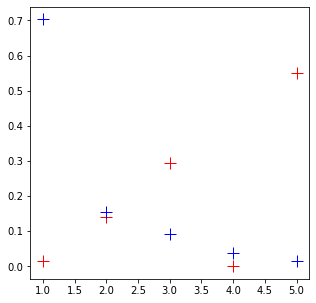

In [21]:
#this shows the fitting for frequency
results_F=metric_F(results)[1]
for i in results_F[setting].keys():
    print (setting,':',i,'//',results_F[setting][i],'//',frequency[setting][i])
    plt.plot(i,results_F[setting][i],'+r',linewidth=1, markersize=12,alpha=1)
    plt.plot(i,frequency[setting][i],'+b',linewidth=1, markersize=12,alpha=1)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()


In [ ]:
#this figure shows evoloution of weights thorough time

for i in nx.edges(results[1]):
    
    plt.plot(range(0,D),results[2][i[0]][i[1]],'k.',linewidth=.01, markersize=.5,alpha=.1)
plt.xlabel("days")
plt.ylabel('weight')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


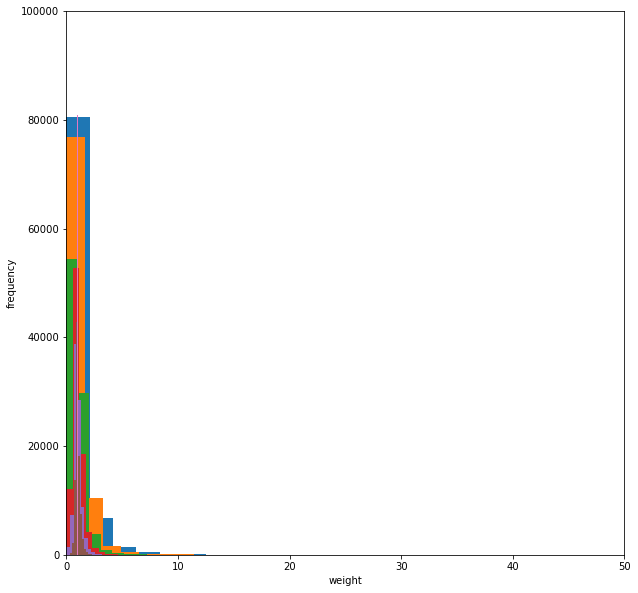

In [18]:
weight_final={0:[],60:[],120:[],180:[],240:[],300:[],359:[]}
for v in weight_final.keys():
    for i in nx.edges(results[1]):
        
        weight_final[v].append(results[2][i[0]][i[1]][v])

for i in reversed(weight_final.keys()):
    plt.hist(weight_final[i],bins=20)
plt.axis([0,50,0,100000])
plt.xlabel("weight")
plt.ylabel('frequency')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

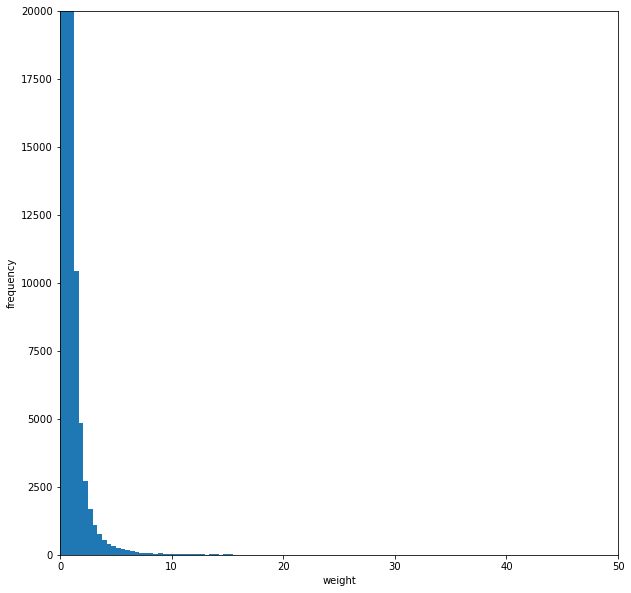

In [19]:
plt.hist(weight_final[359],bins=100)
plt.axis([0,50,0,20000])
plt.xlabel("weight")
plt.ylabel('frequency')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()